In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from obp.ope import RegressionModel
from sklearn.neural_network import MLPRegressor as MLP
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm

from dataset.synthetic import SyntheticBanditDatasetWithCluster
from ope.regression import PairWiseRegression
from ope.meta import OffPolicyEvaluation
from ope.estimator import InversePropensityScore as IPS
from ope.estimator import MarginalizedIPS as MIPS
from ope.estimator import DoublyRobust as DR
from ope.estimator import DirectMethod as DM
from ope.estimator import OFFCEM
from utils.common import visualize_mean_squared_error
from utils.common import aggregate_simulation_results
from policy.function import gen_eps_greedy

In [2]:
def run_ope(
    val_data: dict,
    ope_estimators: list,
    action_dist: np.ndarray,
    true_dist_dict: dict[str, np.ndarray],
    skip_estimation: bool = False
) -> np.ndarray:
    
    if skip_estimation:
        # skip estimation in advance
        val_data["n_learned_clusters"] = val_data["n_true_clusters"] 
        val_data["cluster"] = val_data["true_cluster"]
        val_data["phi_x_a"] = val_data["true_phi_x_a"]
        
        random_ = check_random_state(None)
        
        q_hat = random_.normal(true_dist_dict["q_x_a"], scale=1.)
        
        phi_x_a = val_data["phi_x_a"]
        h_hat = random_.normal(true_dist_dict["h_x_a"], scale=1.)
        g_hat = random_.normal(true_dist_dict["g_x_c"], scale=1.)
        f_hat = h_hat + g_hat[np.arange(val_data["n_users"])[:, None], true_dist_dict["phi_x_a"]]
        
    
    dim_context, n_actions = val_data["context"].shape[1], val_data["n_actions"]
    val_size = val_data["n_rounds"]
    n_learned_clusters = val_data["n_learned_clusters"]

    # off policy evaluation
    ope = OffPolicyEvaluation(
        bandit_feedback=val_data,
        ope_estimators=ope_estimators,
    )
        
    ## train_reward_via_two_stage
    ### 1st-stage
    pairwise_model = PairWiseRegression(
        dim_context=dim_context,
        n_actions=n_actions,
        n_clusters=n_learned_clusters,
        batch_size=512,
        hidden_layer_size=(30, 30, 30),
        learning_rate_init=0.1,
        max_iter=30,
        #early_stopping=True,
        #verbose=True
    )

    h_hat = pairwise_model.fit_predict(bandit_data=val_data)
        
    ### 2nd-stage
    reward = val_data["reward"]
    reward_residual = reward - h_hat[np.arange(val_size), val_data["action"]]
    cluster, phi_x_a = val_data["cluster"], val_data["phi_x_a"][val_data["user_idx"]]

    reg_model = RegressionModel(
        n_actions=n_learned_clusters,
        action_context=np.eye(n_learned_clusters),
        base_model=RandomForestRegressor(n_estimators=10, max_depth=10)
    )

    g_hat = reg_model.fit_predict(
        context=val_data["context"],
        action=cluster,
        reward=reward_residual
    )[:, :, 0]

    f_hat_x_a_e = h_hat + g_hat[np.arange(val_size)[:, None], phi_x_a]
        
    ## one-step reward regression
    reg_model = RegressionModel(
        n_actions=n_actions,
        action_context=val_data["action_context_one_hot"],
        base_model=RandomForestRegressor(n_estimators=10, max_depth=10)
    )
    q_hat_x_a = reg_model.fit_predict(
        context=val_data["context"],
        action=val_data["action"],
        reward=val_data["reward"],
    )[:, :, 0]
    
    # for LC
    q_x_a = true_dist_dict["q_x_a"][val_data["user_idx"]]
        
    q_hat_dict = {
        "DM": q_hat_x_a,
        "DR": q_hat_x_a,
        "OFFCEM": f_hat_x_a_e,
        "OFFCEM (1stage)": q_hat_x_a,
        #"OFFCEM (LC)": q_x_a,
        "OFFCEM (cluster)": np.zeros_like(q_hat_x_a),
    }
        
    estimated_policy_values = ope.estimate_policy_values(action_dist=action_dist, estimated_rewards=q_hat_dict)
    
    return estimated_policy_values

In [3]:
# setting
n_users=30
dim_context=5
n_actions=500
n_cat_per_dim=10
n_cat_dim=5
n_clusters=20
beta=-0.5
eps=0.1
reward_noise=2.0
random_state=12345
n_sim=30

In [4]:
# MSE with varying sample sizes in logged data

sample_sizes = [1000, 2000, 3000]
ope_estimators = [
    #IPS(estimator_name="IPS"),
    DM(estimator_name="DM"),
    DR(estimator_name="DR"),
    #MIPS(estimator_name="MIPS (true)"),
    OFFCEM(estimator_name="OFFCEM"),
    OFFCEM(estimator_name="OFFCEM (1stage)"),
    #OFFCEM(estimator_name="OFFCEM (LC)"),
    OFFCEM(estimator_name="OFFCEM (cluster)")
]

In [5]:
dataset = SyntheticBanditDatasetWithCluster(
    n_users=n_users,
    dim_context=dim_context,
    n_actions=n_actions,
    n_cat_per_dim=n_cat_per_dim,
    n_cat_dim=n_cat_dim,
    n_clusters=n_clusters,
    beta=beta,
    reward_noise=reward_noise,
    random_state=random_state
)

# calc ground truth policy value for all users. ( V(\pi) = \mathbb{E}_{p(u)\pi(a|x_u)p(r|x_u,a)}[r] )
q_x_a = dataset.true_dist_dict["q_x_a"]
policy_value = dataset.calc_ground_truth_policy_value(pi_e=gen_eps_greedy(expected_reward=q_x_a, eps=eps))

result_df_list = []
for val_size in sample_sizes:
    
    result_list = []
    for _ in tqdm(range(n_sim), desc=f"val_size={val_size}"):
        
        # obtain batch bandit data. ( (u_i, x_{u_i}, a_i, r_i) \sim \prod_{i=1}^{n} p(u_i)\pi_{b}(a_i|x_{u_i})p(r_i|x_{u_i}|a_i)  )
        val_data = dataset.obtain_batch_bandit_feedback(n_rounds=val_size)
        
        pi_e = gen_eps_greedy(
            expected_reward=q_x_a[val_data["user_idx"]],
            eps=eps,
        )
        
        estimated_policy_values = run_ope(
            val_data=val_data, ope_estimators=ope_estimators, action_dist=pi_e, true_dist_dict=dataset.true_dist_dict
        )
        
        result_list.append(estimated_policy_values)
    
    # calculate MSE
    result_df = aggregate_simulation_results(
        simulation_result_list=result_list, policy_value=policy_value, x_value=val_size
    )
    result_df_list.append(result_df)

result_df = pd.concat(result_df_list).reset_index(level=0)

val_size=1000: 100% 30/30 [00:58<00:00,  1.96s/it]
val_size=2000: 100% 30/30 [03:05<00:00,  6.19s/it]
val_size=3000: 100% 30/30 [07:50<00:00, 15.69s/it]


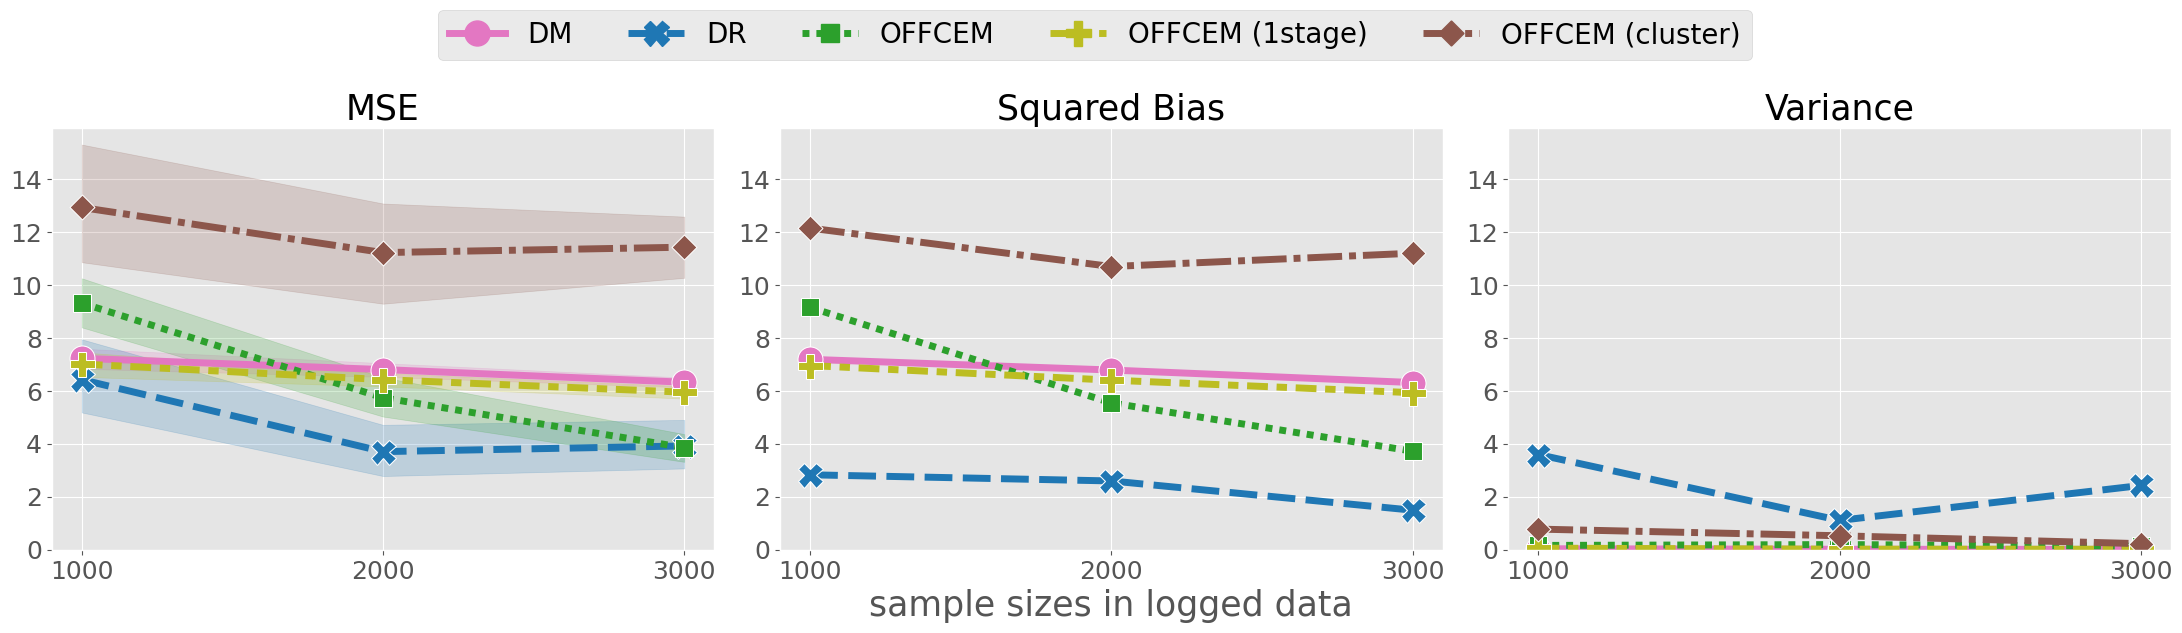

In [6]:
visualize_mean_squared_error(
    result_df=result_df,
    xlabel="sample sizes in logged data",
    yscale="linear"
)

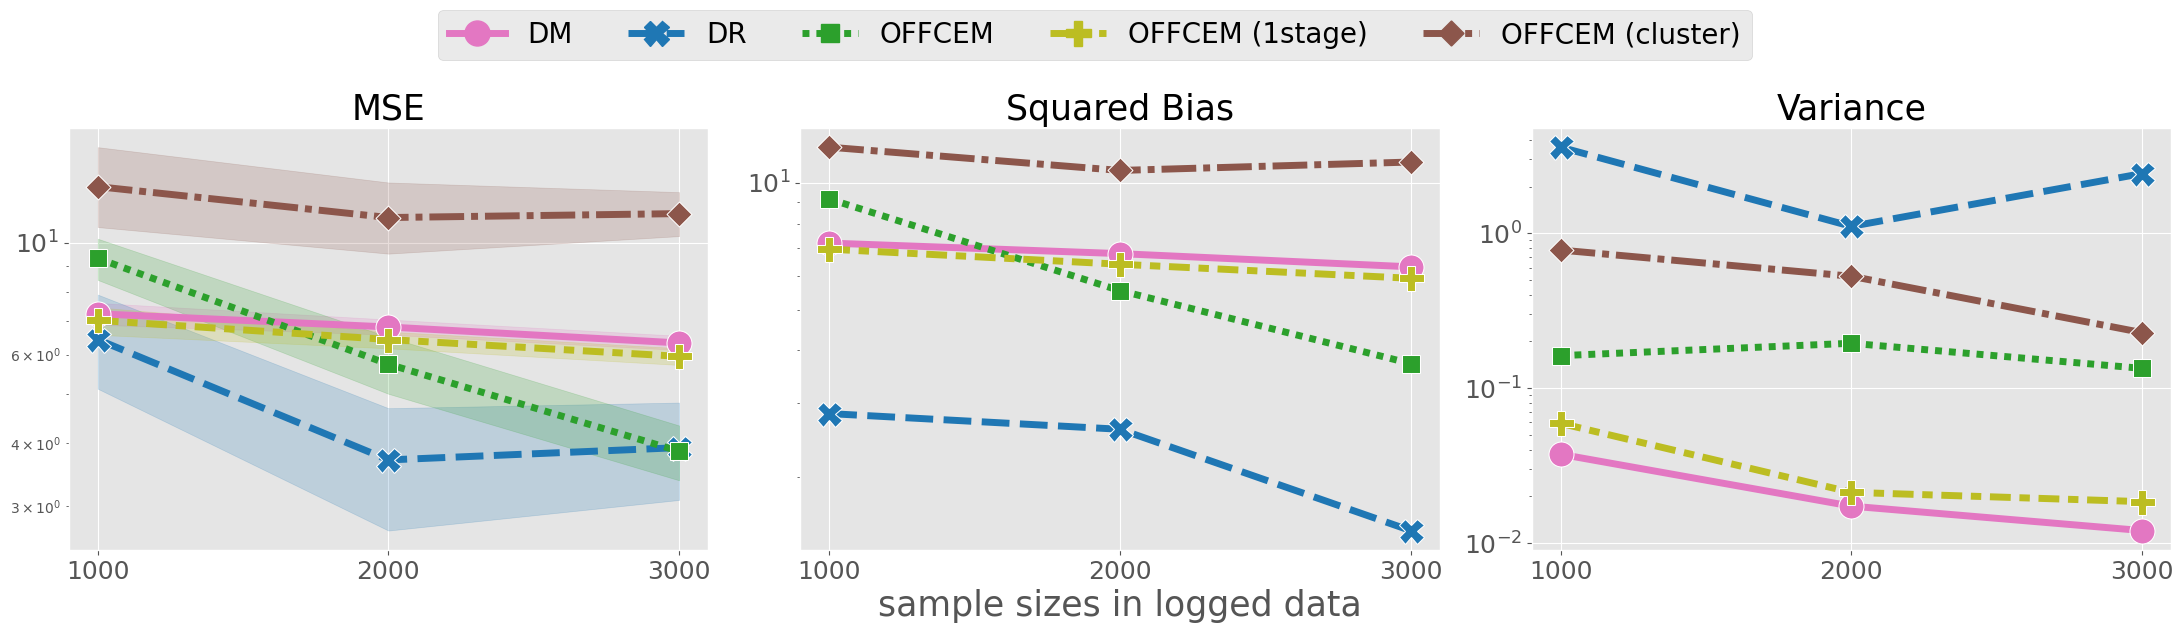

In [7]:
visualize_mean_squared_error(
    #result_df=result_df[result_df["estimator"].isin(["OFFCEM", "OFFCEM (1stage)", "OFFCEM (cluster)"])],
    result_df=result_df,
    xlabel="sample sizes in logged data",
    yscale="log"
)